In [1]:
"""Hierarchical Risk Parity:계층적 군집화와 리스크 패리티 개념을 결합한 방법으로, 자산을 클러스터링하여 리스크를 배분합니다."""


import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.optimize import minimize

desktop_path = 'C:/Users/user/Desktop/DBGAPS/Data'
file_name = '2024-06-25.xlsx'
xls = f'{desktop_path}/{file_name}'
file_path = f'{desktop_path}/{file_name}'





# Load the file into a DataFrame
adjusted_opening_prices_df = pd.read_excel(file_path, sheet_name='Sheet1')

# Set the date column as the index
adjusted_opening_prices_df.set_index('date', inplace=True)
adjusted_opening_prices_df.index = pd.to_datetime(adjusted_opening_prices_df.index)

# Calculate daily returns
returns_df = adjusted_opening_prices_df.pct_change().dropna()





In [2]:
def calculate_sharpe_ratio(returns, risk_free_rate_series):
    """
    샤프 비율을 계산합니다.
    :param returns: 포트폴리오의 수익률 (DataFrame)
    :param risk_free_rate_series: 무위험 수익률 (Series)
    :return: 샤프 비율 (Series)
    """
    # 평균 초과 수익률 계산
    excess_returns = returns.sub(risk_free_rate_series, axis=0).mean()
    
    # 포트폴리오의 변동성 계산
    portfolio_volatility = returns.std()
    
    # 샤프 비율 계산
    sharpe_ratio = excess_returns / portfolio_volatility
    
    # 연환율 변환 (일간 수익률 기준)
    annual_sharpe_ratio = sharpe_ratio * (252**0.5)
    
    return annual_sharpe_ratio

# 무위험 수익률 설정 (A143850의 일간 수익률)
risk_free_rate_series = returns_df['riskfreerate']

# 각 자산의 샤프 비율 계산
sharpe_ratios = calculate_sharpe_ratio(returns_df, risk_free_rate_series)
print('각 자산의 샤프 비율:')
print(sharpe_ratios)


각 자산의 샤프 비율:
A130730        -6.906838
A138230         0.223881
A139660        -1.504359
A114800        -1.276073
A130680         0.199538
A132030         0.682180
A182490         0.206696
A136340        -1.558933
A148070        -0.719029
A192090        -0.000128
A238720         0.514667
A195930         0.514667
A143850         1.205229
A232080         0.321008
A069500         0.735760
riskfreerate    0.000000
dtype: float64


In [3]:
# 무위험 수익률 설정 (A143850의 일간 수익률)
risk_free_rate_series = returns_df['riskfreerate']

def get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df0], ignore_index=True)
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    sort_ix = sort_ix[sort_ix < num_items]
    return sort_ix.tolist()

def get_cluster_var(cov, cluster_items):
    cov_ = cov.loc[cluster_items, cluster_items]
    weights = get_ivp(cov_).values.reshape(-1, 1)
    return np.dot(np.dot(weights.T, cov_), weights)[0, 0]

def get_ivp(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return pd.Series(ivp, index=cov.index)

#재귀적으로 두 개의 하위 클러스터로 나누고, 각 클러스터의 분산을 계산하여 최적의 가중치로 조정
def get_rec_bipart(cov, sort_ix):
    weights = pd.Series(1, index=sort_ix)
    cluster_items = [sort_ix]
    while len(cluster_items) > 0:
        cluster_items = [i[j:k] for i in cluster_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        for i in range(0, len(cluster_items), 2):
            c_items0 = cluster_items[i]
            c_items1 = cluster_items[i + 1]
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            weights[c_items0] *= alpha
            weights[c_items1] *= 1 - alpha
    return weights

def compute_hrp_weights_with_objective(returns, risk_free_rate):
    correlation_matrix = returns.corr()
    distance_matrix = np.sqrt((1 - correlation_matrix) / 2)
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    covariance_matrix = returns.cov()
    sort_ix = get_quasi_diag(linkage_matrix)
    sort_ix = returns.columns[sort_ix].tolist()
    hrp_weights = get_rec_bipart(covariance_matrix, sort_ix)
    
    # Calculate portfolio statistics
    portfolio_returns = (returns * hrp_weights).sum(axis=1)
    excess_returns = portfolio_returns.mean() - risk_free_rate.mean()
    portfolio_volatility = portfolio_returns.std()
    sharpe_ratio = excess_returns / portfolio_volatility
    
    return hrp_weights, sharpe_ratio

# 제약 조건 함수: 가중치의 합이 1이 되도록 함
def constraint(weights):
    return np.sum(weights) - 1

constraints = [{'type': 'eq', 'fun': constraint}]



# 샤프 비율이 음수인 자산의 비중을 낮추고, 양수인 자산의 비중을 높이는 방식으로 가중치 조정
def adjust_weights_for_sharpe_ratios(weights, sharpe_ratios):
    adjusted_weights = weights.copy()
    for asset in weights.index:
        if sharpe_ratios[asset] < 0:
            adjusted_weights[asset] *= 0.5  # 샤프 비율이 음수인 경우 비중을 절반으로 줄임
        else:
            adjusted_weights[asset] *= 1.5  # 샤프 비율이 양수인 경우 비중을 1.5배로 늘림
    # 비중의 합이 1이 되도록 다시 조정
    adjusted_weights /= adjusted_weights.sum()
    return adjusted_weights



In [27]:

# 각 자산별 기본 최소 및 최대 비중 설정
min_weights = {asset: 0.0 for asset in returns_df.columns}
max_weights = {asset: 1.0 for asset in returns_df.columns}
min_weights_basic = {asset: 0.0 for asset in returns_df.columns}

# 특정 자산에 대해 최소 및 최대 비중 설정 (필요한 경우)
min_weights.update({
    'A238720': 0.0,
    'A143850': 0.0,
    'A182490': 0.05
})
max_weights.update({
    'A238720': 0.2,
    'A143850': 0.2,
    'A130680': 0.15,
    'A195930': 0.0,   # 유로스탁스 자산비중 제한
    'A232080': 0.2,
    'A069500': 0.4
})


# 각 자산별 최소 및 최대 비중을 bounds로 설정
bounds = [(min_weights[asset], max_weights[asset]) for asset in returns_df.columns]
bounds_unandjusted  = [(min_weights_basic[asset], None) for asset in returns_df.columns]

# 초기 가중치로 np.ones 사용
initial_weights = np.ones(len(returns_df.columns)) / len(returns_df.columns)

# 최적화 수행
result = minimize(objective_function, initial_weights, args=(returns_df, risk_free_rate_series),
                  method='SLSQP', bounds=bounds_unandjusted, constraints=constraints)

# 최적화된 가중치
optimized_weights = pd.Series(result.x, index=returns_df.columns)

# 가중치의 합이 1이 되도록 다시 조정
optimized_weights /=optimized_weights.sum()

print('최적화된 가중치:')
print(optimized_weights.round(3))


# 최종 포트폴리오의 샤프 비율 계산
optimized_portfolio_returns = (returns_df * optimized_weights).sum(axis=1)
optimized_sharpe_ratio = calculate_sharpe_ratio(optimized_portfolio_returns, risk_free_rate_series)



print(f'최적화된 포트폴리오 샤프 비율: {optimized_sharpe_ratio:.4f}')



# 최적화 수행
result_minmax = minimize(objective_function, initial_weights, args=(returns_df, risk_free_rate_series),
                  method='SLSQP', bounds=bounds, constraints=constraints)



# 각 자산의 샤프 비율을 계산
sharpe_ratios = calculate_sharpe_ratio(returns_df, risk_free_rate_series)
# 샤프 비율 기반으로 가중치를 조정
adjusted_weights = adjust_weights_for_sharpe_ratios(optimized_weights, sharpe_ratios)
#adjusted_minmax_weights = adjust_weights_to_bounds(adjusted_weights,min_weights, max_weights)
adjusted_minmax_weights = pd.Series(result_minmax.x, index=returns_df.columns)

print('조정된 가중치:')
print(adjusted_minmax_weights.round(2))

# 최종 포트폴리오의 샤프 비율 계산
final_portfolio_returns = (returns_df * adjusted_minmax_weights).sum(axis=1)
final_sharpe_ratio = calculate_sharpe_ratio(final_portfolio_returns, risk_free_rate_series)
print(f'최종 포트폴리오 샤프 비율: {final_sharpe_ratio:.4f}')



최적화된 가중치:
A130730         0.000
A138230         0.506
A139660         0.000
A114800         0.000
A130680         0.000
A132030         0.177
A182490         0.000
A136340         0.000
A148070         0.000
A192090         0.000
A238720         0.000
A195930         0.000
A143850         0.270
A232080         0.000
A069500         0.046
riskfreerate    0.000
dtype: float64
최적화된 포트폴리오 샤프 비율: 1.6398
조정된 가중치:
A130730         0.00
A138230         0.50
A139660         0.00
A114800         0.00
A130680         0.00
A132030         0.17
A182490         0.05
A136340         0.00
A148070         0.00
A192090         0.00
A238720         0.00
A195930         0.00
A143850         0.20
A232080         0.00
A069500         0.08
riskfreerate    0.00
dtype: float64
최종 포트폴리오 샤프 비율: 1.5849


In [28]:
import numpy as np

# Define the objective function
def objective_function(weights, returns_df, risk_free_rate_series):
    # Calculate portfolio returns
    portfolio_returns = np.dot(weights, returns_df.T)
    # Calculate portfolio mean return
    mean_return = np.mean(portfolio_returns)
    # Calculate portfolio standard deviation
    std_dev = np.std(portfolio_returns)
    # Calculate Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate_series.mean()) / std_dev
    # Return the negative Sharpe ratio (because we want to maximize the Sharpe ratio)
    return -sharpe_ratio

# Your existing code here
# 각 자산별 기본 최소 및 최대 비중 설정
min_weights = {asset: 0.0 for asset in returns_df.columns}
max_weights = {asset: 1.0 for asset in returns_df.columns}
min_weights_basic = {asset: 0.0 for asset in returns_df.columns}

# 특정 자산에 대해 최소 및 최대 비중 설정 (필요한 경우)
min_weights.update({
    'A238720': 0.0,
    'A143850': 0.0,
    'A182490': 0.05,
    'A130730': 0.01,
    'A069500': 0.1
})
max_weights.update({
    'A238720': 0.2,
    'A143850': 0.2,
    'A130680': 0.15,
    'A195930': 0.0,   # 유로스탁스 자산비중 제한
    'A232080': 0.2,
    'A069500': 0.4,
    'A138230':0.2,
    'A132030':0.15
})

# 각 자산별 최소 및 최대 비중을 bounds로 설정
bounds = [(min_weights[asset], max_weights[asset]) for asset in returns_df.columns]
bounds_unandjusted = [(min_weights_basic[asset], None) for asset in returns_df.columns]

# 초기 가중치로 np.ones 사용
initial_weights = np.ones(len(returns_df.columns)) / len(returns_df.columns)

# 제약 조건 정의 (예: 가중치의 합이 1이 되도록)
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# 최적화 수행
result = minimize(objective_function, initial_weights, args=(returns_df, risk_free_rate_series),
                  method='SLSQP', bounds=bounds_unandjusted, constraints=constraints)

# 최적화된 가중치
optimized_weights = pd.Series(result.x, index=returns_df.columns)

# 가중치의 합이 1이 되도록 다시 조정
optimized_weights /= optimized_weights.sum()

print('최적화된 가중치:')
print(optimized_weights.round(3))

# 최종 포트폴리오의 샤프 비율 계산
optimized_portfolio_returns = (returns_df * optimized_weights).sum(axis=1)
optimized_sharpe_ratio = calculate_sharpe_ratio(optimized_portfolio_returns, risk_free_rate_series)

print(f'최적화된 포트폴리오 샤프 비율: {optimized_sharpe_ratio:.4f}')

# 최적화 수행
result_minmax = minimize(objective_function, initial_weights, args=(returns_df, risk_free_rate_series),
                         method='SLSQP', bounds=bounds, constraints=constraints)

# 각 자산의 샤프 비율을 계산
sharpe_ratios = calculate_sharpe_ratio(returns_df, risk_free_rate_series)

# 샤프 비율 기반으로 가중치를 조정
adjusted_weights = adjust_weights_for_sharpe_ratios(optimized_weights, sharpe_ratios)
#adjusted_minmax_weights = adjust_weights_to_bounds(adjusted_weights,min_weights, max_weights)
adjusted_minmax_weights = pd.Series(result_minmax.x, index=returns_df.columns)

print('조정된 가중치:')
print(adjusted_minmax_weights.round(2))

# 최종 포트폴리오의 샤프 비율 계산
final_portfolio_returns = (returns_df * adjusted_minmax_weights).sum(axis=1)
final_sharpe_ratio = calculate_sharpe_ratio(final_portfolio_returns, risk_free_rate_series)
print(f'최종 포트폴리오 샤프 비율: {final_sharpe_ratio:.4f}')


최적화된 가중치:
A130730         0.000
A138230         0.506
A139660         0.000
A114800         0.000
A130680         0.000
A132030         0.177
A182490         0.000
A136340         0.000
A148070         0.000
A192090         0.000
A238720         0.000
A195930         0.000
A143850         0.270
A232080         0.000
A069500         0.046
riskfreerate    0.000
dtype: float64
최적화된 포트폴리오 샤프 비율: 1.6398
조정된 가중치:
A130730         0.01
A138230         0.20
A139660         0.00
A114800         0.00
A130680         0.00
A132030         0.15
A182490         0.05
A136340         0.29
A148070         0.00
A192090         0.00
A238720         0.00
A195930         0.00
A143850         0.20
A232080         0.00
A069500         0.10
riskfreerate    0.00
dtype: float64
최종 포트폴리오 샤프 비율: 1.2430


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


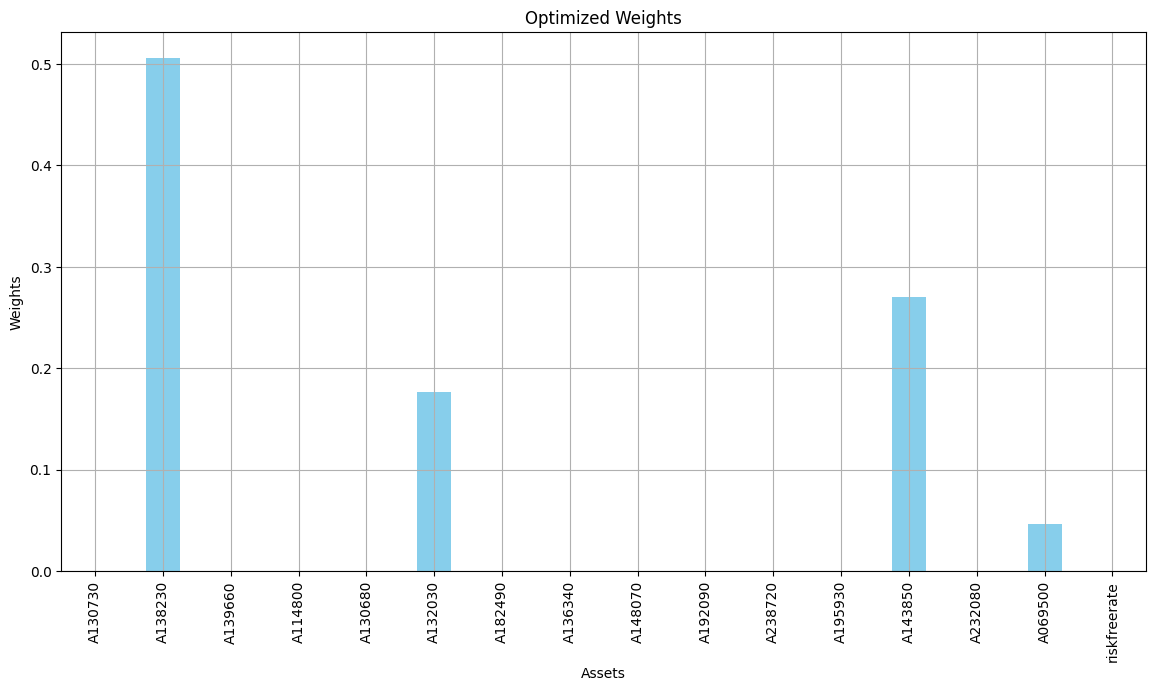

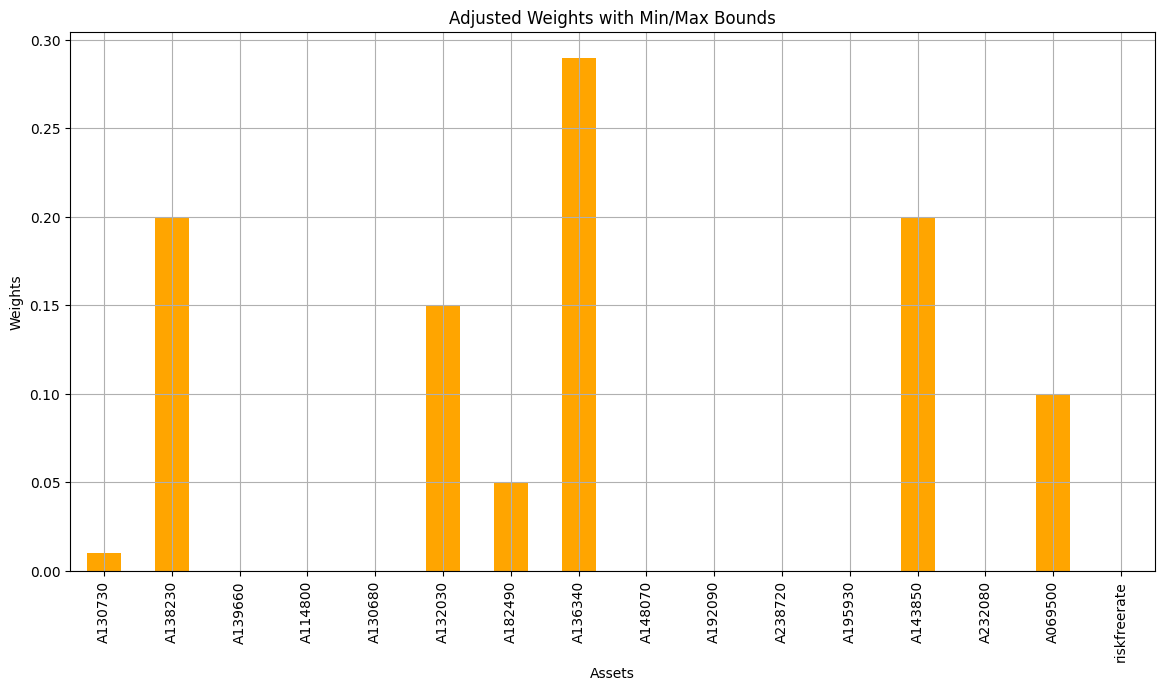

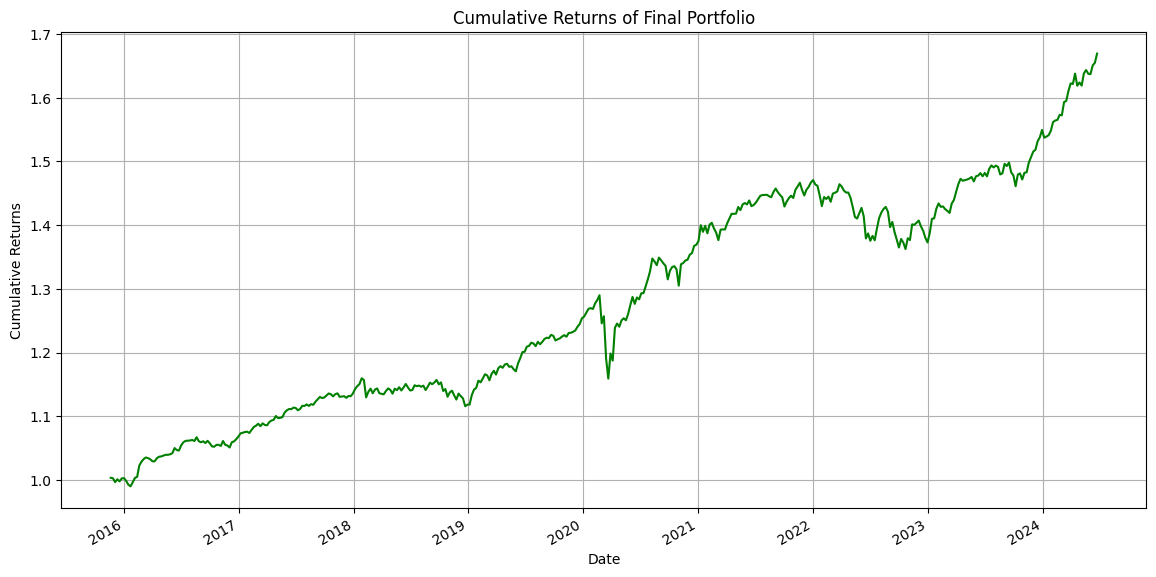

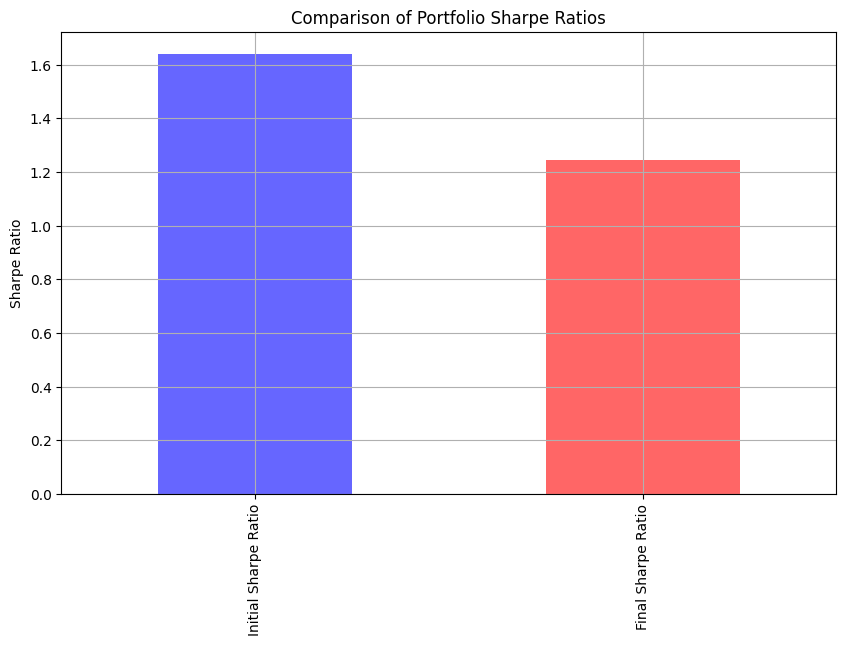

In [29]:
import matplotlib.pyplot as plt

# 최적화된 가중치 시각화
plt.figure(figsize=(14, 7))
optimized_weights.plot(kind='bar', color='skyblue')
plt.title('Optimized Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.grid(True)
plt.show()

# 조정된 가중치 시각화
plt.figure(figsize=(14, 7))
adjusted_minmax_weights.plot(kind='bar', color='orange')
plt.title('Adjusted Weights with Min/Max Bounds')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.grid(True)
plt.show()

# 최종 포트폴리오 수익률 시각화
final_portfolio_cumulative_returns = (1 + final_portfolio_returns).cumprod()

plt.figure(figsize=(14, 7))
final_portfolio_cumulative_returns.plot(color='green')
plt.title('Cumulative Returns of Final Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# 최종 포트폴리오의 샤프 비율 비교
sharpe_ratios_comparison = pd.Series([optimized_sharpe_ratio, final_sharpe_ratio], 
                                     index=['Initial Sharpe Ratio', 'Final Sharpe Ratio'])

plt.figure(figsize=(10, 6))
sharpe_ratios_comparison.plot(kind='bar', color=['blue', 'red'], alpha=0.6)
plt.title('Comparison of Portfolio Sharpe Ratios')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()



In [25]:
def backtest_portfolio(returns, weights, start_date=None, end_date=None, freq='M'):
    """
    주어진 가중치를 사용하여 포트폴리오의 백테스팅을 수행합니다.
    
    :param returns: 자산의 일간 수익률 (DataFrame)
    :param weights: 포트폴리오의 자산별 가중치 (Series)
    :param start_date: 백테스팅 시작 날짜 (datetime)
    :param end_date: 백테스팅 종료 날짜 (datetime)
    :param freq: 수익률 계산 빈도 (기본값: 'M' - 월간)
    :return: 포트폴리오의 수익률 (Series), 포트폴리오의 누적 수익률 (Series), 포트폴리오의 변동성 (Series)
    """
    # 날짜 범위가 지정된 경우 해당 기간의 수익률 데이터만 사용
    if start_date is not None and end_date is not None:
        returns = returns[start_date:end_date]
    
    # 리샘플링하여 빈도에 맞춘 수익률 계산
    returns_resampled = returns.resample(freq).apply(lambda x: (1 + x).prod() - 1)
    
    # 포트폴리오의 수익률 계산
    portfolio_returns = (returns_resampled * weights).sum(axis=1)
    
    # 포트폴리오의 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # 포트폴리오의 변동성 계산 (rolling window로 계산)
    rolling_volatility = portfolio_returns.rolling(window=12).std() * np.sqrt(12)  # 월간 변동성
    
    return portfolio_returns, cumulative_returns, rolling_volatility

C:\Users\user\AppData\Local\Temp\ipykernel_17344\4072441506.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_resampled = returns.resample(freq).apply(lambda x: (1 + x).prod() - 1)


5년간 샤프 비율로 최적화된 포트폴리오 일간 수익률 (최근 5년):
date
2019-06-30    0.001618
2019-07-31    0.020509
2019-08-31    0.015319
2019-09-30    0.000599
2019-10-31   -0.008233
Freq: ME, dtype: float64

HRP로 최적화된 포트폴리오 일간 수익률 (최근 5년):


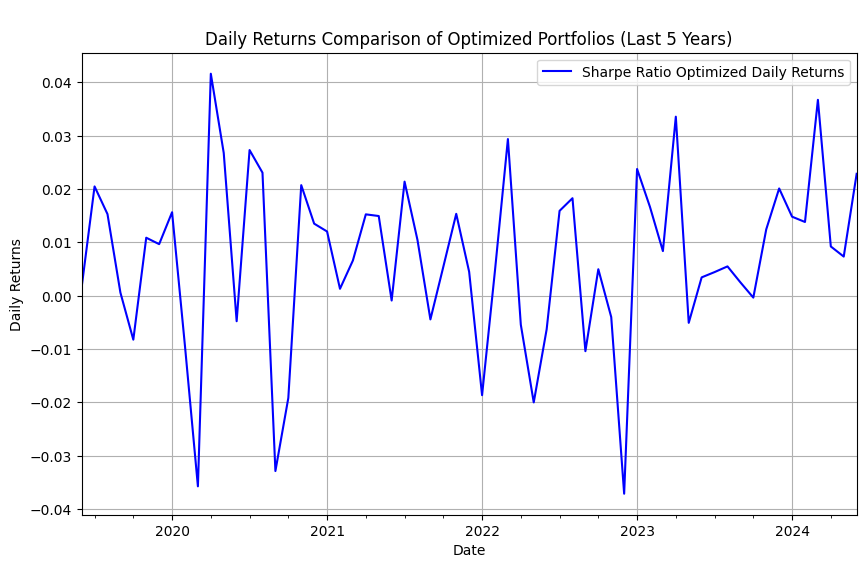

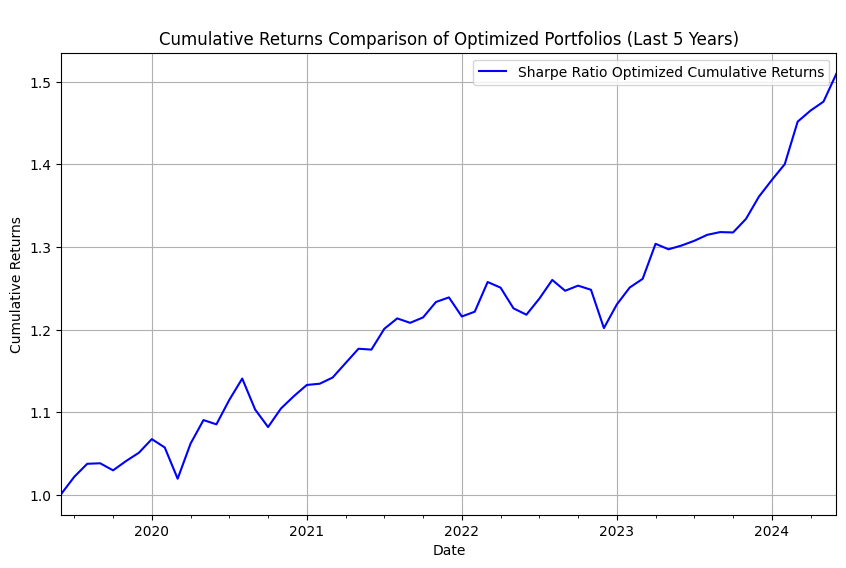

In [9]:
# period = n
period=5

# 최근 3년 동안의 수익률 데이터 가져오기
end_date = returns_df.index[-1]
start_date = end_date - pd.DateOffset(years=period)

# 샤프 비율로 최적화된 가중치를 사용하여 최근 n년 동안 백테스팅 수행
sharpe_optimized_weights = pd.Series(result.x, index=returns_df.columns)
sharpe_portfolio_returns, sharpe_cumulative_returns, sharpe_rolling_volatility = backtest_portfolio(
    returns_df, sharpe_optimized_weights, start_date=start_date, end_date=end_date)

# HRP로 최적화된 가중치를 사용하여 최근 n년 동안 백테스팅 수행
#hrp_portfolio_returns, hrp_cumulative_returns, hrp_rolling_volatility = backtest_portfolio(
#    returns_df, adjusted_weights, start_date=start_date, end_date=end_date)

# 백테스팅 결과 출력

print(f"{period}년간 샤프 비율로 최적화된 포트폴리오 일간 수익률 (최근 {period}년):")
print(sharpe_portfolio_returns.head())
print(f"\nHRP로 최적화된 포트폴리오 일간 수익률 (최근 {period}년):")
#print(hrp_portfolio_returns.head())

# 백테스팅 결과 시각화

plt.figure(figsize=(10, 6))
sharpe_portfolio_returns.plot(color='blue', label='Sharpe Ratio Optimized Daily Returns')
plt.title(f"\nDaily Returns Comparison of Optimized Portfolios (Last {period} Years)")
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sharpe_cumulative_returns.plot(color='blue', label='Sharpe Ratio Optimized Cumulative Returns')
#hrp_cumulative_returns.plot(color='green', label='HRP Optimized Cumulative Returns', alpha=0.6)
plt.title(f"\nCumulative Returns Comparison of Optimized Portfolios (Last {period} Years)")
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


